<a href="https://colab.research.google.com/github/mokoshin0720/ml-tutorials/blob/main/Transformer-with-Encoder-Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インストール -> 再起動

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

!pip install torchtext==0.8.0
!pip install torch==1.7.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

# 必要なモジュールのimport

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.metrics import bleu_score
from torchtext import data
from torchtext.data import Field
import MeCab

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# データの前処理

分かち書き

In [ ]:
def tokenizer(text):
    return m.parse(text).split()

In [ ]:
m = MeCab.Tagger("-Owakati")

# Fieldオブジェクトの作成
japanese = data.Field(tokenize=tokenizer, init_token="<sos>", eos_token="<eos>")
english = data.Field(lower=True,  init_token="<sos>", eos_token="<eos>")

# CSVファイルを読み込み、TabularDatasetオブジェクトを作成
train_data, test_data = data.TabularDataset.splits(
    path = "/content/drive/MyDrive/data/nakazawa_lab/translate",
    train = "train.csv",
    test = "test.csv",
    format="csv",
    fields=[('japanese', japanese), ('english', english)]
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

単語辞書の作成

In [ ]:
japanese.build_vocab(train_data)
english.build_vocab(train_data)

# Transformerモデル

In [132]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        '''
        Embedding
        '''
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size) # 普通に単語埋め込み
        self.src_position_embedding = nn.Embedding(max_len, embedding_size) # positionはどうやっているのだろうか...?
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size) # 普通に単語埋め込み(target)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size) # positionはどうやっているのだろうか...?

        '''
        Encoder
        '''
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_size,
            nhead=num_heads,
            dim_feedforward=forward_expansion,
            dropout=dropout,
            )
        encoder_norm = nn.LayerNorm(normalized_shape=embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_encoder_layers,
            norm=encoder_norm
        )

        '''
        Decoder
        '''
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embedding_size,
            nhead=num_heads,
            dim_feedforward=forward_expansion,
            dropout=dropout,
        )
        decoder_norm = nn.LayerNorm(normalized_shape=embedding_size)

        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=num_decoder_layers,
            norm=decoder_norm
        )

        '''
        生成機構
        '''
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)

        self.device = device
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx
        return src_mask.to(self.device)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length) # 0からsrc_seq_lengthまでの数値列 -> (1, src_seq_length)
            .unsqueeze(1)                   # 1次元目のサイズを1にする（転置）   -> (src_seq_length, 1)
            .expand(src_seq_length, N)      # ↑の行をN個作る                 -> (src_seq_length, N)
            .to(self.device)
        )
        '''
        tensor([[0, 0, 0, 0, 0],
                [1, 1, 1, 1, 1],
                [2, 2, 2, 2, 2]])
        みたいな感じで位置ベクトルを表している。（多分、バッチ分作っているはず）
        '''

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        # srcと　trgの単語埋め込み
        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        # mask処理
        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.generate_square_subsequent_mask(trg_seq_length).to(self.device)

        memory = self.encoder(
            src=embed_src,
            src_key_padding_mask=src_padding_mask
        )

        out = self.decoder(
            tgt=embed_trg,
            memory=memory,
            tgt_mask=trg_mask,
            # memory_maskが必要かも...
        )

        # 生成機構
        out = self.fc_out(out)
        return out

# ハイパーパラメータ

In [ ]:
num_epochs = 10
learning_rate = 3e-4
batch_size = 32

In [ ]:
src_vocab_size = len(japanese.vocab)
trg_vocab_size = len(english.vocab)
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len = 100
forward_expansion = 4
src_pad_idx = 0

# 学習

In [ ]:
train_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, test_data),
        batch_size=batch_size,
        sort_within_batch=True,
        sort_key=lambda x: len(x.japanese),
        device=device,
        )

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")
    model.train()
    losses = []
    mean_losses = []

    for batch_idx, batch in enumerate(train_iterator):
        inp_data = batch.japanese.to(device) # inputバッチ
        target = batch.english.to(device) # outputバッチ

        output = model(inp_data, target[:-1, :]) # モデルにデータを入れて、結果を出力

        # lossを計算するために、outputとtargetの形式を変換
        output = output.reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        optimizer.zero_grad()
        loss = criterion(output, target)
        losses.append(loss.item())

        # 誤差逆伝搬
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    mean_losses.append(mean_loss)
    print(mean_loss)

checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
save_checkpoint(checkpoint)

[Epoch 0 / 10]


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


4.079603820800782
[Epoch 1 / 10]
3.434240509033203
[Epoch 2 / 10]
3.034095960617065
[Epoch 3 / 10]
2.7122885465621946
[Epoch 4 / 10]
2.4153146171569824
[Epoch 5 / 10]
2.1161952047348023
[Epoch 6 / 10]
1.8161240949630737
[Epoch 7 / 10]
1.5258800196647644
[Epoch 8 / 10]
1.2329664130210876
[Epoch 9 / 10]
0.9809396920204163
=> Saving checkpoint


損失関数の可視化

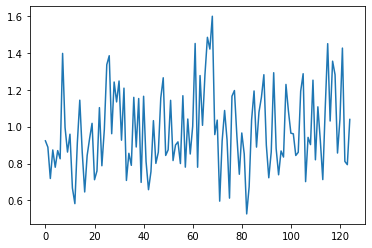

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

# 予測

In [ ]:
model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

In [ ]:
def translate_sentence(model, sentence, japanese, english, device, max_length=50):
    if type(sentence) == str:
        tokens = [token for token in tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, japanese.init_token)
    tokens.append(japanese.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [japanese.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    outputs = [english.vocab.stoi["<sos>"]]
    # outputs = [english.vocab.stoi["<sos>"], english.vocab.stoi["on"], english.vocab.stoi["test"]]
    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)

        best_guess = output.argmax(2)[-1, :].item()
        outputs.append(best_guess)

        if best_guess == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    # remove start token
    return translated_sentence[1:]

In [ ]:
sentence = "店にもう在庫が無い"

In [ ]:
translated_sentence = translate_sentence(
        model, sentence, japanese, english, device, max_length=50
    )
print(f"Translated example sentence: \n {translated_sentence}")

Translated example sentence: 
 ['the', 'store', 'is', 'out', 'of', 'stock.', '<eos>']
